<a href="https://colab.research.google.com/github/123gamal/Water_Flood_prediction_Satalite_images_image_segmentation/blob/main/flood_prediction_pretrained_model_segformer_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers datasets torch torchvision tifffile pillow
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile as tiff
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSemanticSegmentation
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/data-20250917T185435Z-1-001/data"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
MASK_DIR  = os.path.join(BASE_DIR, "labels")

def load_image(path):
    img = tiff.imread(path).astype(np.float32)
    img = img[:, :, [3,2,1]]
    img = img / np.max(img)
    return img

def load_mask(path):
    mask = np.array(Image.open(path))
    mask = (mask > 0).astype(np.uint8)
    return mask


image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(".tif")])
mask_files  = sorted(os.listdir(MASK_DIR))

image_paths, mask_paths = [], []
for img_name in image_files:
    base = os.path.splitext(img_name)[0]
    for ext in [".png", ".jpg", ".tif"]:
        mask_name = base + ext
        if mask_name in mask_files:
            image_paths.append(os.path.join(IMAGE_DIR, img_name))
            mask_paths.append(os.path.join(MASK_DIR, mask_name))
            break

print(f"✅ Matched pairs: {len(image_paths)}")


class WaterSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = load_image(self.image_paths[idx])
        mask = load_mask(self.mask_paths[idx])

        img = torch.tensor(img).permute(2,0,1).float()
        mask = torch.tensor(mask).long()

        return img, mask


train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_dataset = WaterSegmentationDataset(train_imgs, train_masks)
val_dataset   = WaterSegmentationDataset(val_imgs, val_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Matched pairs: 306


In [4]:
model = AutoModelForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)

in_channels = model.decode_head.classifier.in_channels
model.decode_head.classifier = nn.Conv2d(in_channels, 2, kernel_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def compute_iou(pred_mask, true_mask):
    pred = pred_mask.cpu().numpy()
    true = true_mask.cpu().numpy()
    intersection = np.logical_and(true, pred).sum()
    union = np.logical_or(true, pred).sum()
    return intersection / (union + 1e-6)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

In [6]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss, train_iou = 0, 0

        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values=imgs).logits

            outputs = torch.nn.functional.interpolate(
                outputs,
                size=masks.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_iou += compute_iou(preds, masks)

        model.eval()
        val_loss, val_iou = 0, 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(pixel_values=imgs).logits
                outputs = torch.nn.functional.interpolate(
                    outputs,
                    size=masks.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
                val_loss += criterion(outputs, masks).item()
                preds = torch.argmax(outputs, dim=1)
                val_iou += compute_iou(preds, masks)

        print(f"Epoch {epoch+1}/{epochs} "
              f"- Train Loss: {train_loss/len(train_loader):.4f}, IoU: {train_iou/len(train_loader):.4f} "
              f"- Val Loss: {val_loss/len(val_loader):.4f}, IoU: {val_iou/len(val_loader):.4f}")

train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10 - Train Loss: 0.5399, IoU: 0.3915 - Val Loss: 0.4519, IoU: 0.4779
Epoch 2/10 - Train Loss: 0.3768, IoU: 0.5480 - Val Loss: 0.3359, IoU: 0.4928
Epoch 3/10 - Train Loss: 0.3300, IoU: 0.5653 - Val Loss: 0.3225, IoU: 0.5298
Epoch 4/10 - Train Loss: 0.2855, IoU: 0.6230 - Val Loss: 0.3263, IoU: 0.5242
Epoch 5/10 - Train Loss: 0.2778, IoU: 0.6203 - Val Loss: 0.3032, IoU: 0.5336
Epoch 6/10 - Train Loss: 0.2699, IoU: 0.6294 - Val Loss: 0.2643, IoU: 0.5659
Epoch 7/10 - Train Loss: 0.2547, IoU: 0.6416 - Val Loss: 0.3224, IoU: 0.5385
Epoch 8/10 - Train Loss: 0.2446, IoU: 0.6586 - Val Loss: 0.3056, IoU: 0.5644
Epoch 9/10 - Train Loss: 0.2386, IoU: 0.6586 - Val Loss: 0.3099, IoU: 0.5454
Epoch 10/10 - Train Loss: 0.2268, IoU: 0.6762 - Val Loss: 0.2604, IoU: 0.5797


In [14]:
import torch.nn.functional as F
def test_model(model, image_path, mask_path=None, threshold=0.5):
    model.eval()
    img = load_image(image_path)
    X = torch.tensor(img).permute(2,0,1).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(pixel_values=X).logits
        pred = F.interpolate(pred, size=(img.shape[0], img.shape[1]), mode="bilinear", align_corners=False)
        pred_mask = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

    rgb_img = (img - img.min()) / (img.max() - img.min())

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(rgb_img)
    plt.title("Input (RGB)")

    if mask_path:
        gt_mask = load_mask(mask_path)
        plt.subplot(1,3,2)
        plt.imshow(gt_mask, cmap="gray")
        plt.title("Ground Truth")

        intersection = np.logical_and(gt_mask, pred_mask).sum()
        union = np.logical_or(gt_mask, pred_mask).sum()
        iou = intersection / (union + 1e-6)
        print(f"IoU: {iou:.4f}")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Prediction")
    plt.show()


IoU: 0.9133


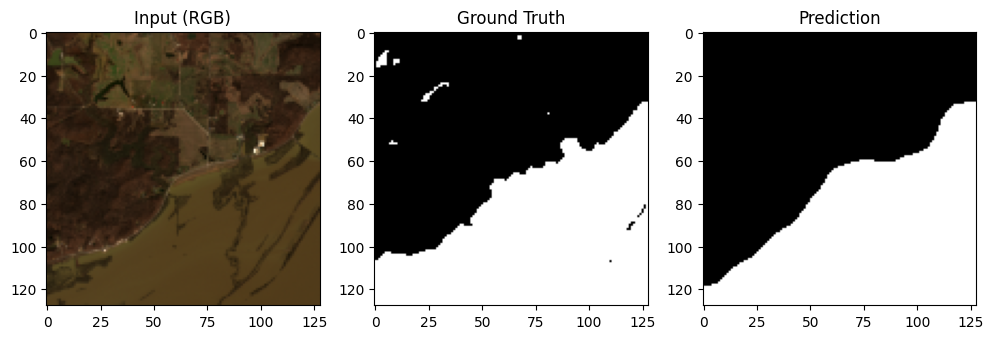

In [32]:
test_model(model=model, image_path="/content/drive/MyDrive/data-20250917T185435Z-1-001/data/images/52.tif", mask_path="/content/drive/MyDrive/data-20250917T185435Z-1-001/data/labels/52.png", threshold=0.5)
